# Notebook 2 – Perfilado y reporte de calidad (FraSoHome)

**Objetivo (formativo):** diagnosticar la calidad de los datos de las fuentes *raw* (CRM, e-commerce, POS, ERP) antes de limpiarlos.

En este notebook vamos a:

1. Cargar los CSV de origen **sin “arreglarlos”** (para conservar los errores intencionales).
2. Realizar un **perfilado**: nulos, duplicados, cardinalidad, distribuciones.
3. Medir **calidad de parseo** de fechas e importes (formatos heterogéneos).
4. Ejecutar **checks de consistencia básica** (PK, FK, rangos, reconciliaciones).
5. Generar un **Data Quality Report** (tabla de hallazgos) exportable a CSV.

> Nota: Este notebook está pensado para acompañar el *Notebook 1 – Ingesta y tipado*.  
> Aun así, es **autocontenido**: define sus propias funciones y vuelve a leer los CSV.


## 0) Setup y carga de archivos
- Estrategia: leer con `dtype=str` para no perder valores “raros” (€, comas, espacios, etc.).
- Luego, en el perfilado, **intentamos parsear** fechas y números para medir cuántos valores “fallan”.

Ajusta `DATA_DIR` si tus CSV están en otra carpeta.


In [2]:
# Debemos de tener matplotlib instalado para poder ejecutar este notebook

from __future__ import annotations

import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display  # para notebooks
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 80)

DATA_DIR = Path("data/raw/")  # <-- ajusta si tus CSV están en otra ruta

EXPECTED_FILES = {
    "crm": "crm.csv",
    "productos": "productos.csv",
    "tiendas": "tiendas.csv",
    "pedidos": "pedidos.csv",
    "lineas_pedido": "lineas_pedido.csv",
    "devoluciones_online": "devoluciones_online.csv",
    "ventas_pos": "ventas_pos.csv",
    "devoluciones_tienda": "devoluciones_tienda.csv",
    "pagos_tienda": "pagos_tienda.csv",
    "stock_diario": "stock_diario.csv",
    # opcional (si lo tienes): fact integrada
    "fact_transacciones": "fact_transacciones.csv",
}

def read_csv_raw(path: Path, *, encoding: str = "utf-8", sep: str = ",") -> pd.DataFrame:
    """Lee CSV en modo 'raw' conservando problemas de formato.

    - dtype=str para evitar conversiones automáticas
    - na_values para que blanks y marcadores típicos cuenten como NaN
    """
    na_values = ["", " ", "NA", "N/A", "null", "None", "nan", "NaN"]
    return pd.read_csv(
        path,
        encoding=encoding,
        sep=sep,
        dtype=str,
        keep_default_na=True,
        na_values=na_values,
    )

def load_sources(data_dir: Path, expected: dict[str, str]) -> dict[str, pd.DataFrame]:
    dfs: dict[str, pd.DataFrame] = {}
    for name, fname in expected.items():
        fpath = data_dir / fname
        if not fpath.exists():
            print(f"⚠️ No encontrado: {fpath} (se omite '{name}')")
            continue
        dfs[name] = read_csv_raw(fpath)
    return dfs

dfs = load_sources(DATA_DIR, EXPECTED_FILES)

# Accesos rápidos (si existe cada dataset)
crm = dfs.get("crm")
productos = dfs.get("productos")
tiendas = dfs.get("tiendas")
pedidos = dfs.get("pedidos")
lineas_pedido = dfs.get("lineas_pedido")
devoluciones_online = dfs.get("devoluciones_online")
ventas_pos = dfs.get("ventas_pos")
devoluciones_tienda = dfs.get("devoluciones_tienda")
pagos_tienda = dfs.get("pagos_tienda")
stock_diario = dfs.get("stock_diario")
fact_transacciones = dfs.get("fact_transacciones")

list(dfs.keys())


['crm',
 'productos',
 'tiendas',
 'pedidos',
 'lineas_pedido',
 'devoluciones_online',
 'ventas_pos',
 'devoluciones_tienda',
 'pagos_tienda',
 'stock_diario',
 'fact_transacciones']

## 1) Inspección rápida por dataset (shape, columnas, ejemplos)

La idea es responder rápido a:
- ¿Cuántas filas/columnas hay?
- ¿Qué pinta tienen los datos?
- ¿Hay columnas “críticas” ausentes?


In [3]:
def basic_overview(df: pd.DataFrame, name: str, head: int = 5) -> None:
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columnas:", list(df.columns))
    display(df.head(head))

for name, df in dfs.items():
    basic_overview(df, name, head=3)



=== crm ===
shape: (103, 20)
columnas: ['customer_id', 'nombre', 'apellidos', 'email', 'telefono', 'fecha_alta_programa', 'tier_fidelizacion', 'puntos_acumulados', 'fecha_nacimiento', 'genero', 'ciudad', 'provincia', 'codigo_postal', 'pais', 'consentimiento_marketing', 'estado_cliente', 'fecha_baja', 'origen_alta', 'canal_preferido_declarado', 'ultima_actualizacion']


,customer_id,nombre,apellidos,email,telefono,fecha_alta_programa,tier_fidelizacion,puntos_acumulados,fecha_nacimiento,genero,ciudad,provincia,codigo_postal,pais,consentimiento_marketing,estado_cliente,fecha_baja,origen_alta,canal_preferido_declarado,ultima_actualizacion
0,C0001,Bruno,PérezFernández,NaN,+34 662 454 433,23/12/2018,Bronce,3590,25/01/1966,NaN,Sevilla,Sevilla,41001,ES,no,Bloqueado,2024-11-20,NaN,Online,28/06/25 11:38
1,C0002,Bárbara,MartínezRubio,barbara.martinezrubio@example.com,627112365,07/07/2018,Platino,2241,1992-11-03,F,Gijón,Asturias,33201,ES,1,Inactivo,2025-02-16,tienda,Mixto,2025-01-08 01:51:20
2,C0003,Rita,NavarroDíaz,rita.navarrodiaz@example.com,NaN,2024-04-18,Plata,2.073,NaN,F,Córdoba,Córdoba,14001,ES,YES,Activo,NaN,NaN,Mixto,2025-09-28 00:43:46



=== productos ===
shape: (101, 18)
columnas: ['product_id', 'nombre_producto', 'categoria', 'subcategoria', 'marca', 'proveedor', 'material', 'color', 'precio_venta', 'coste_unitario', 'iva_pct', 'peso_kg', 'largo_cm', 'ancho_cm', 'alto_cm', 'fecha_alta_catalogo', 'estado_producto', 'ean']


,product_id,nombre_producto,categoria,subcategoria,marca,proveedor,material,color,precio_venta,coste_unitario,iva_pct,peso_kg,largo_cm,ancho_cm,alto_cm,fecha_alta_catalogo,estado_producto,ean
0,P1000,Sofá Aurora 160cm,Muebles,Sofás,UrbanHome,NaN,Lino,Beige,221.99,143.47,21,24.63,134.0,13.5,20.3,2022-08-27,Activo,8386379402654
1,P1001,Cuadro Atlas ★,Decoración,Cuadros,TextilPlus,Prov_Mediterraneo,Metal,Negro,31.63,21.79,21,4.85,97.8,59.7,34.5,2023-01-23,Activo,8495931034131
2,P1002,Sábana Brisa 90x200,Textil hogar,Sábanas,CasaViva,Prov_Mediterraneo,Algodón,Verde,169.18,106.71,21,5.48,13.2,52.6,34.4,2022-09-08,Activo,7648350305641



=== tiendas ===
shape: (8, 19)
columnas: ['store_id', 'nombre_tienda', 'tipo_ubicacion', 'canal', 'ciudad', 'provincia', 'direccion', 'codigo_postal', 'pais', 'fecha_apertura', 'metros_cuadrados', 'telefono', 'horario', 'lat', 'lon', 'estado', 'region', 'gerente', 'observaciones']


,store_id,nombre_tienda,tipo_ubicacion,canal,ciudad,provincia,direccion,codigo_postal,pais,fecha_apertura,metros_cuadrados,telefono,horario,lat,lon,estado,region,gerente,observaciones
0,S001,FraSoHome Madrid Centro,Tienda,FISICO,Madrid,Madrid,C/ Gran Vía 45,28013,ES,2016-03-15,1850,+34 910 123 001,L-S 10:00-21:30,40.4203,-3.7058,Activa,Centro,Marta Sánchez,NaN
1,S002,FraSoHome Barcelona Eixample,Tienda,FISICO,Barcelona,Barcelona,Av. Diagonal 212,08002,ES,15/07/2017,2100,0034 930 555 002,L-S 09:30-21:00,41.3879,2.16992,Activa,Cataluña,Jordi Pujol,NaN
2,S003,FraSoHome Valencia Ruzafa,Tienda,FISICO,Valencia,Valencia,C/ Cádiz 8,46001,ES,10 de Enero de 2019,1600,961-778-003,L-D 10:00-22:00,39.4669,-0.3763,Activa,Levante,Álvaro Muñoz,NaN



=== pedidos ===
shape: (656, 16)
columnas: ['order_id', 'fecha_pedido', 'customer_id', 'usuario_online_id', 'importe_total', 'moneda', 'gastos_envio', 'direccion_envio', 'codigo_postal_envio', 'ciudad_envio', 'provincia_envio', 'pais_envio', 'metodo_pago', 'estado_pedido', 'origen', 'ultima_actualizacion']


,order_id,fecha_pedido,customer_id,usuario_online_id,importe_total,moneda,gastos_envio,direccion_envio,codigo_postal_envio,ciudad_envio,provincia_envio,pais_envio,metodo_pago,estado_pedido,origen,ultima_actualizacion
0,O-202400001,2025-05-11 15:46:46,C0014,UO-542417,2621.36,EUR,9.99,Gran Vía 24,08002,Barcelona,Barcelona,ES,Tarjeta,Pendiente,marketplace,2025-05-24 15:46:46
1,O-202400002,20/03/2024 09:20,C0006,NaN,€1342.89,EUR,0.00,Calle Mayor 142,31001,Pamplona,Navarra,ES,Tarjeta,Devuelto Parcial,marketplace,2024-04-01 09:20:15
2,O-202400003,2024-05-06 08:05:31,C9999,NaN,750.88,EUR,4.99,"Rúa do Príncipe 187, 4ºB",20003,San Sebastián,Gipuzkoa,ES,Tarjeta,Entregado,marketplace,2024-05-16 08:05:31



=== lineas_pedido ===
shape: (1949, 12)
columnas: ['order_line_id', 'order_id', 'product_id', 'descripcion_producto', 'categoria', 'subcategoria', 'cantidad', 'precio_unitario', 'descuento_pct', 'descuento_importe', 'importe_linea', 'iva_pct']


,order_line_id,order_id,product_id,descripcion_producto,categoria,subcategoria,cantidad,precio_unitario,descuento_pct,descuento_importe,importe_linea,iva_pct
0,OL-0000001,O-202400001,P1078,Estantería Atlas 160cm,Muebles,Estanterías,2,730.66,NaN,NaN,1461.32,21
1,OL-0000002,O-202400001,P1071,"Bombilla Aurora ""Star""",Iluminación,Bombillas,1,134.46,5,6.72,"127,74",21
2,OL-0000003,O-202400001,P1051,Alfombra Aurora Set 2 uds,Textil hogar,Alfombras,1,"22,62",5,1.13,21.49,21



=== devoluciones_online ===
shape: (224, 12)
columnas: ['return_id', 'order_id', 'order_line_id', 'product_id', 'fecha_devolucion', 'cantidad_devuelta', 'motivo_devolucion', 'metodo_devolucion', 'estado_devolucion', 'importe_reembolsado', 'moneda', 'comentarios']


,return_id,order_id,order_line_id,product_id,fecha_devolucion,cantidad_devuelta,motivo_devolucion,metodo_devolucion,estado_devolucion,importe_reembolsado,moneda,comentarios
0,RO-2025-00001,O-202400014,OL-0000041,P1058,2025-04-04 16:59:55,2,NaN,tienda,Pendiente,"103,00",EUR,Etiqueta de envío ilegible
1,RO-2025-00002,O-202400014,OL-0000040,P1003,2025-04-18 07:24:55,2,No encaja / medidas,Envío,Pendiente,"384,80",EUR,NaN
2,RO-2025-00003,O-202400014,OL-0000039,P1055,2025-05-22 11:59:55,1,No encaja / medidas,Tienda,Reembolsada,"121,38",EUR,Reembolso parcial por uso



=== ventas_pos ===
shape: (2521, 19)
columnas: ['ticket_line_id', 'ticket_id', 'fecha_hora', 'store_id', 'caja_id', 'cajero_id', 'customer_id', 'product_id', 'descripcion_producto', 'categoria', 'subcategoria', 'cantidad', 'precio_unitario', 'descuento_pct', 'descuento_importe', 'importe_linea', 'moneda', 'canal', 'observaciones']


,ticket_line_id,ticket_id,fecha_hora,store_id,caja_id,cajero_id,customer_id,product_id,descripcion_producto,categoria,subcategoria,cantidad,precio_unitario,descuento_pct,descuento_importe,importe_linea,moneda,canal,observaciones
0,TL-000001,T-500000,13/12/25 11:42,S001,CAJ04,EMP014,c0030,P1065,Sofá Atlas 3 plazas,Muebles,Sofás,1,1192.40,5,€59.62,1132.78,EUR,POS,NaN
1,TL-000002,T-500000,13/12/25 11:42,S001,CAJ04,EMP014,c0030,P1000,Sofá Aurora 160cm,NaN,Sofás,1,"221,53",25,55.38,166.15,EUR,POS,NaN
2,TL-000003,T-500001,04/03/25 00:07,S005,CAJ08,EMP001,NaN,P1041,Vela Luna ★,Decoración,Velas,1,124.95,0,0.00,124.95,EUR,POS,NaN



=== devoluciones_tienda ===
shape: (211, 16)
columnas: ['return_id', 'fecha_devolucion', 'store_id', 'ticket_id_original', 'ticket_line_id_original', 'order_id_original', 'customer_id', 'product_id', 'cantidad_devuelta', 'estado_devolucion', 'importe_reembolsado', 'moneda', 'metodo_reembolso', 'motivo_devolucion', 'canal_origen_venta', 'comentarios']


,return_id,fecha_devolucion,store_id,ticket_id_original,ticket_line_id_original,order_id_original,customer_id,product_id,cantidad_devuelta,estado_devolucion,importe_reembolsado,moneda,metodo_reembolso,motivo_devolucion,canal_origen_venta,comentarios
0,RT-2025-00001,14 de septiembre de 2025 08:25,S003,T-500097,TL-000197,NaN,C0033,P1058,1,Aceptada,65.94,EUR,Transferencia,Cambio de opinión,POS,NaN
1,RT-2025-00002,20/11/25 20:43,S003,T-500477,TL-000987,NaN,c0001,P1003,0,Aceptada,0.00,EUR,Efectivo,Cambio de opinión,POS,sin ticket
2,RT-2025-00003,2025-07-07,S002,T-500521,TL-001091,NaN,NaN,P1043,1,Aceptada,"€894,68",EUR,Efectivo,No encaja en el espacio,POS,NaN



=== pagos_tienda ===
shape: (1646, 12)
columnas: ['payment_id', 'ticket_id', 'fecha_pago', 'store_id', 'caja_id', 'cajero_id', 'metodo_pago', 'importe_pagado', 'moneda', 'referencia_autorizacion', 'estado_pago', 'observaciones']


,payment_id,ticket_id,fecha_pago,store_id,caja_id,cajero_id,metodo_pago,importe_pagado,moneda,referencia_autorizacion,estado_pago,observaciones
0,PAY-0000001,T-500031,2025-09-28 10:29:00,S004,CAJ02,EMP074,CC,€848.91,EUR,NQ4FMYZY,OK,NaN
1,PAY-0000002,T-500031,28/09/25 10:29,S004,CAJ02,EMP074,Vale,113.42,EUR,OC6UZHR5XF,OK,NaN
2,PAY-0000003,T-500039,07/04/25 00:50,S003,CAJ02,EMP006,Visa/Mastercard,66.51,EUR,VQJT7YE511M,OK,NaN



=== stock_diario ===
shape: (1940, 9)
columnas: ['fecha', 'store_id', 'product_id', 'stock_cierre', 'stock_reservado', 'stock_en_transito', 'stock_minimo', 'fuente', 'comentarios']


,fecha,store_id,product_id,stock_cierre,stock_reservado,stock_en_transito,stock_minimo,fuente,comentarios
0,2025-09-01 03:05:24,S001,P1043,14.0,1.0,0.0,2,ERP,NaN
1,2025-09-01,S001,P1061,11.0,2.0,0.0,5,ERP,NaN
2,2025-09-01,S002,p1005,60.0,1.0,0.0,7,ERP,NaN



=== fact_transacciones ===
shape: (4973, 59)
columnas: ['fact_id', 'source_system', 'source_file', 'canal_origen', 'canal_movimiento', 'tipo_movimiento', 'es_devolucion', 'fecha_movimiento_raw', 'fecha_movimiento', 'store_id_raw', 'store_id_std', 'doc_tipo', 'doc_id_raw', 'doc_id_std', 'line_id_raw', 'line_id_std', 'return_id', 'customer_id_raw', 'customer_id_std', 'flag_customer_in_crm', 'product_id_raw', 'product_id_std', 'flag_product_in_master', 'descripcion_producto', 'categoria', 'subcategoria', 'cantidad_raw', 'cantidad_signed', 'cantidad_abs', 'precio_unitario_raw', 'precio_unitario_num', 'descuento_pct_raw', 'descuento_pct_num', 'descuento_importe_raw', 'descuento_importe_num', 'importe_linea_raw', 'importe_signed_num', 'importe_abs_num', 'moneda', 'iva_pct', 'coste_unitario_num', 'coste_total_num', 'margen_bruto_num', 'metodo_pago', 'estado_pedido', 'origen', 'ticket_id_original', 'ticket_line_id_original', 'order_id_original', 'order_line_id_original', 'motivo_devolucion', 

,fact_id,source_system,source_file,canal_origen,canal_movimiento,tipo_movimiento,es_devolucion,fecha_movimiento_raw,fecha_movimiento,store_id_raw,store_id_std,doc_tipo,doc_id_raw,doc_id_std,line_id_raw,line_id_std,return_id,customer_id_raw,customer_id_std,flag_customer_in_crm,product_id_raw,product_id_std,flag_product_in_master,descripcion_producto,categoria,subcategoria,cantidad_raw,cantidad_signed,cantidad_abs,precio_unitario_raw,precio_unitario_num,descuento_pct_raw,descuento_pct_num,descuento_importe_raw,descuento_importe_num,importe_linea_raw,importe_signed_num,importe_abs_num,moneda,iva_pct,coste_unitario_num,coste_total_num,margen_bruto_num,metodo_pago,estado_pedido,origen,ticket_id_original,ticket_line_id_original,order_id_original,order_line_id_original,motivo_devolucion,metodo_devolucion,caja_id,cajero_id,flag_fecha_parseada,flag_importe_parseado,nombre_producto,precio_venta_num,estado_producto
0,F000001,ECOM,lineas_pedido.csv,ONLINE,ONLINE,VENTA,0,2025-05-11 15:46:46,2025-05-11 15:46:46,ONLINE,ONLINE,ORDER,O-202400001,O-202400001,OL-0000001,OL-0000001,NaN,C0014,C0014,1,P1078,P1078,1,Estantería Atlas 160cm,Muebles,Estanterías,2,2.0,2.0,730.66,730.66,NaN,NaN,NaN,NaN,1461.32,1461.32,1461.32,EUR,21,497.07,994.14,467.17999999999995,Tarjeta,Pendiente,marketplace,NaN,NaN,O-202400001,OL-0000001,NaN,NaN,NaN,NaN,1,1,Estantería Atlas 160cm,702.02,Activo
1,F000002,ECOM,lineas_pedido.csv,ONLINE,ONLINE,VENTA,0,2025-05-11 15:46:46,2025-05-11 15:46:46,ONLINE,ONLINE,ORDER,O-202400001,O-202400001,OL-0000002,OL-0000002,NaN,C0014,C0014,1,P1071,P1071,1,"Bombilla Aurora ""Star""",Iluminación,Bombillas,1,1.0,1.0,134.46,134.46,5,5.0,6.72,6.72,"127,74",127.74,127.74,EUR,21,81.49,81.49,46.25,Tarjeta,Pendiente,marketplace,NaN,NaN,O-202400001,OL-0000002,NaN,NaN,NaN,NaN,1,1,"Bombilla Aurora ""Star""",136.91,Descatalogado
2,F000003,ECOM,lineas_pedido.csv,ONLINE,ONLINE,VENTA,0,2025-05-11 15:46:46,2025-05-11 15:46:46,ONLINE,ONLINE,ORDER,O-202400001,O-202400001,OL-0000003,OL-0000003,NaN,C0014,C0014,1,P1051,P1051,1,Alfombra Aurora Set 2 uds,Textil hogar,Alfombras,1,1.0,1.0,"22,62",22.62,5,5.0,1.13,1.13,21.49,21.49,21.49,EUR,21,12.4,12.4,9.089999999999998,Tarjeta,Pendiente,marketplace,NaN,NaN,O-202400001,OL-0000003,NaN,NaN,NaN,NaN,1,1,Alfombra Aurora Set 2 uds,23.53,Descatalogado


## 2) Perfilado básico: nulos, duplicados exactos, cardinalidad

Esto no “limpia” nada; solo cuantifica el estado de los datos.


,dataset,rows,cols,missing_cells,missing_cells_pct,duplicate_rows_exact,duplicate_rows_pct
10,fact_transacciones,4973,59,47653,0.162413,0,0.000000
6,ventas_pos,2521,19,4534,0.094658,30,0.011900
4,lineas_pedido,1949,12,1875,0.080169,8,0.004105
9,stock_diario,1940,9,2015,0.115407,14,0.007216
8,pagos_tienda,1646,12,2010,0.101762,10,0.006075
3,pedidos,656,16,831,0.079173,2,0.003049
5,devoluciones_online,224,12,243,0.090402,0,0.000000
7,devoluciones_tienda,211,16,516,0.152844,0,0.000000
0,crm,103,20,214,0.103883,1,0.009709
1,productos,101,18,18,0.009901,0,0.000000


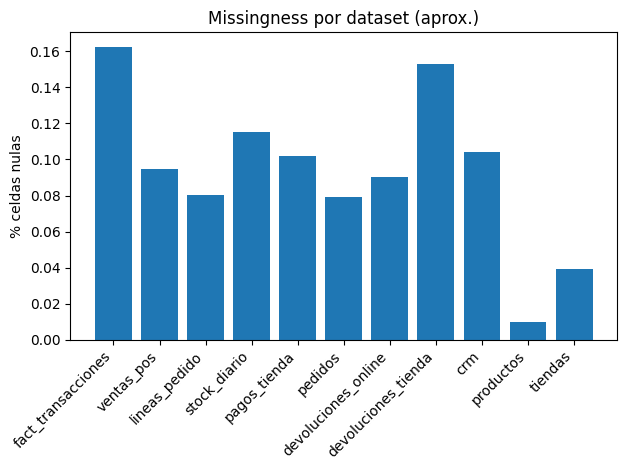

In [4]:
def table_summary(df: pd.DataFrame, name: str) -> dict:
    total_cells = df.shape[0] * df.shape[1] if df.shape[1] else 0
    missing_cells = int(df.isna().sum().sum())
    dup_rows = int(df.duplicated().sum())
    return {
        "dataset": name,
        "rows": df.shape[0],
        "cols": df.shape[1],
        "missing_cells": missing_cells,
        "missing_cells_pct": (missing_cells / total_cells) if total_cells else np.nan,
        "duplicate_rows_exact": dup_rows,
        "duplicate_rows_pct": (dup_rows / df.shape[0]) if df.shape[0] else np.nan,
    }

summary_df = pd.DataFrame([table_summary(df, name) for name, df in dfs.items()]).sort_values(["rows"], ascending=False)
display(summary_df)

# (Opcional) mini-plot para ver % nulos por tabla
plt.figure()
plt.bar(summary_df["dataset"], summary_df["missing_cells_pct"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("% celdas nulas")
plt.title("Missingness por dataset (aprox.)")
plt.tight_layout()
plt.show()


In [5]:
def missingness_report(df: pd.DataFrame, *, top_n: int = 20) -> pd.DataFrame:
    miss = df.isna().sum()
    pct = (miss / len(df)) if len(df) else np.nan
    out = pd.DataFrame({"missing": miss, "missing_pct": pct}).sort_values("missing", ascending=False)
    return out.head(top_n)

def cardinality_report(df: pd.DataFrame, *, top_n: int = 20) -> pd.DataFrame:
    nun = df.nunique(dropna=True)
    pct = (nun / len(df)) if len(df) else np.nan
    out = pd.DataFrame({"n_unique": nun, "unique_ratio": pct}).sort_values("n_unique", ascending=False)
    return out.head(top_n)

# Ejemplo: nulos y cardinalidad en CRM
if crm is not None:
    display(missingness_report(crm, top_n=30))
    display(cardinality_report(crm, top_n=30))


,missing,missing_pct
fecha_baja,54,0.524272
genero,44,0.427184
origen_alta,24,0.233010
canal_preferido_declarado,21,0.203883
fecha_nacimiento,18,0.174757
consentimiento_marketing,14,0.135922
telefono,13,0.126214
email,7,0.067961
tier_fidelizacion,7,0.067961
codigo_postal,5,0.048544


,n_unique,unique_ratio
customer_id,101,0.980583
ultima_actualizacion,101,0.980583
fecha_alta_programa,99,0.961165
apellidos,99,0.961165
puntos_acumulados,95,0.922330
email,93,0.902913
telefono,87,0.844660
fecha_nacimiento,83,0.805825
nombre,71,0.689320
fecha_baja,47,0.456311


## 3) Calidad de parseo: fechas e importes (formatos heterogéneos)

Los CSV contienen fechas y cantidades en formatos mixtos (ISO, DD/MM, texto con meses en español, €, coma decimal, etc.).  
En este paso no “arreglamos” definitivamente: **medimos** cuántos valores se pueden convertir y cuáles fallan.

### 3.1 Funciones reutilizables


In [6]:
SPANISH_MONTHS = {
    "enero": "01", "febrero": "02", "marzo": "03", "abril": "04", "mayo": "05", "junio": "06",
    "julio": "07", "agosto": "08", "septiembre": "09", "setiembre": "09", "octubre": "10",
    "noviembre": "11", "diciembre": "12",
}

def _normalize_spanish_date_text(s: str) -> str:
    """Normaliza fechas tipo '10 de Enero de 2023' -> '10 01 2023'."""
    if s is None:
        return s
    s2 = str(s).strip().lower()
    # quita 'de'
    s2 = re.sub(r"\bde\b", " ", s2)
    # reemplaza meses por número
    for m, num in SPANISH_MONTHS.items():
        s2 = re.sub(rf"\b{m}\b", num, s2)
    # colapsa espacios
    s2 = re.sub(r"\s+", " ", s2).strip()
    return s2

def parse_datetime_es(series: pd.Series, *, dayfirst: bool = True) -> pd.Series:
    """Intenta parsear una serie a datetime manejando casos comunes del caso FraSoHome."""
    if series is None:
        return series
    s = series.astype("string")
    s = s.str.strip()
    # normalización para meses en español
    s_norm = s.map(lambda x: _normalize_spanish_date_text(x) if pd.notna(x) else x)
    dt = pd.to_datetime(s_norm, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)
    # segundo intento (más permisivo) sobre los que fallaron
    mask = dt.isna() & s_norm.notna()
    if mask.any():
        dt2 = pd.to_datetime(s_norm[mask], errors="coerce", dayfirst=dayfirst)
        dt.loc[mask] = dt2
    return dt

def date_parse_report(df: pd.DataFrame, col: str, *, dayfirst: bool = True, sample_bad: int = 8) -> pd.Series:
    if col not in df.columns:
        return pd.Series({"col": col, "exists": False})
    dt = parse_datetime_es(df[col], dayfirst=dayfirst)
    total = len(df)
    non_null = int(df[col].notna().sum())
    parsed = int(dt.notna().sum())
    failed = non_null - parsed
    sample = df.loc[dt.isna() & df[col].notna(), col].head(sample_bad).tolist()
    return pd.Series({
        "col": col,
        "exists": True,
        "rows": total,
        "non_null": non_null,
        "parsed_ok": parsed,
        "failed_parse": failed,
        "parse_success_rate": (parsed / non_null) if non_null else np.nan,
        "sample_failed_values": sample,
    })

def parse_numeric(series: pd.Series) -> pd.Series:
    """Parse robusto para importes: soporta €, EUR, comas/puntos, miles."""
    if series is None:
        return series
    s = series.astype("string").str.strip()
    # vacíos -> NA
    s = s.replace({"": pd.NA})
    # quita símbolos y texto
    s = s.str.replace("€", "", regex=False)
    s = s.str.replace("EUR", "", regex=False).str.replace("eur", "", regex=False)
    s = s.str.replace(" ", "", regex=False)

    def _to_float(x: str):
        if x is None or pd.isna(x):
            return np.nan
        x = str(x)
        # si hay ambos separadores, decide por el último (heurística)
        if "," in x and "." in x:
            if x.rfind(",") > x.rfind("."):
                # coma decimal
                x = x.replace(".", "")
                x = x.replace(",", ".")
            else:
                # punto decimal
                x = x.replace(",", "")
        else:
            # solo coma -> decimal
            if "," in x:
                x = x.replace(".", "")  # por si acaso
                x = x.replace(",", ".")
            # solo punto: puede ser decimal o miles (ej. 1.250)
            elif "." in x:
                parts = x.split(".")
                if len(parts) == 2 and len(parts[1]) == 3 and len(parts[0]) >= 1:
                    # probable separador de miles
                    x = parts[0] + parts[1]
        try:
            return float(x)
        except Exception:
            return np.nan

    return s.map(_to_float)

def numeric_parse_report(df: pd.DataFrame, col: str, sample_bad: int = 8) -> pd.Series:
    if col not in df.columns:
        return pd.Series({"col": col, "exists": False})
    num = parse_numeric(df[col])
    total = len(df)
    non_null = int(df[col].notna().sum())
    parsed = int(num.notna().sum())
    failed = non_null - parsed
    sample = df.loc[num.isna() & df[col].notna(), col].head(sample_bad).tolist()
    return pd.Series({
        "col": col,
        "exists": True,
        "rows": total,
        "non_null": non_null,
        "parsed_ok": parsed,
        "failed_parse": failed,
        "parse_success_rate": (parsed / non_null) if non_null else np.nan,
        "sample_failed_values": sample,
    })


In [7]:
DATE_COLS = {
    "crm": ["fecha_alta_programa", "fecha_nacimiento", "fecha_baja", "ultima_actualizacion"],
    "productos": ["fecha_alta_catalogo"],
    "tiendas": ["fecha_apertura"],
    "pedidos": ["fecha_pedido", "ultima_actualizacion"],
    "lineas_pedido": [],
    "devoluciones_online": ["fecha_devolucion"],
    "ventas_pos": ["fecha_hora"],
    "devoluciones_tienda": ["fecha_devolucion"],
    "pagos_tienda": ["fecha_pago"],
    "stock_diario": ["fecha"],
    "fact_transacciones": ["fecha_movimiento_raw", "fecha_movimiento"],
}

NUM_COLS = {
    "crm": ["puntos_acumulados"],
    "productos": ["precio_venta", "coste_unitario", "peso_kg", "largo_cm", "ancho_cm", "alto_cm"],
    "tiendas": ["metros_cuadrados", "lat", "lon"],
    "pedidos": ["importe_total", "gastos_envio"],
    "lineas_pedido": ["cantidad", "precio_unitario", "descuento_pct", "descuento_importe", "importe_linea"],
    "devoluciones_online": ["cantidad_devuelta", "importe_reembolsado"],
    "ventas_pos": ["cantidad", "precio_unitario", "descuento_pct", "descuento_importe", "importe_linea"],
    "devoluciones_tienda": ["cantidad_devuelta", "importe_reembolsado"],
    "pagos_tienda": ["importe_pagado"],
    "stock_diario": ["stock_cierre", "stock_reservado", "stock_en_transito", "stock_minimo"],
}

# Reporte de parseo de fechas
date_reports = []
for name, cols in DATE_COLS.items():
    df = dfs.get(name)
    if df is None:
        continue
    for col in cols:
        if col in df.columns:
            r = date_parse_report(df, col)
            r["dataset"] = name
            date_reports.append(r)
date_report_df = pd.DataFrame(date_reports).sort_values(["parse_success_rate"], ascending=True)
display(date_report_df)

# Reporte de parseo numérico
num_reports = []
for name, cols in NUM_COLS.items():
    df = dfs.get(name)
    if df is None:
        continue
    for col in cols:
        if col in df.columns:
            r = numeric_parse_report(df, col)
            r["dataset"] = name
            num_reports.append(r)
num_report_df = pd.DataFrame(num_reports).sort_values(["parse_success_rate"], ascending=True)
display(num_report_df.head(30))


C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s_norm, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:33: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt2 = pd.to_datetime(s_norm[mask], errors="coerce", dayfirst=dayfirst)
C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing

,col,exists,rows,non_null,parsed_ok,failed_parse,parse_success_rate,sample_failed_values,dataset
13,fecha_movimiento_raw,True,4973,4962,1181,3781,0.238009,"[2024/06/14 03:38:45, 2024/06/14 03:38:45, 2024/06/14 03:38:45, 2024/06/14 0...",fact_transacciones
12,fecha,True,1940,1938,692,1246,0.357069,"[01/09/2025, 2025/09/02, 02/09/2025, 02/09/2025, 02/09/2025, 02/09/25, 02/09...",stock_diario
6,fecha_pedido,True,656,656,296,360,0.451220,"[2024/06/14 03:38:45, 2024-10-25 20:34:57, 2025-10-15 17:51:13, 2024/02/17 0...",pedidos
8,fecha_devolucion,True,224,224,133,91,0.593750,"[2024/05/16 04:08:00, 23/10/2024 12:59, 07/02/2024 17:56, 2024-02-11, 01/02/...",devoluciones_online
1,fecha_nacimiento,True,103,85,53,32,0.623529,"[1960-05-15, 1959-01-17, 1997-08-19, 1952-05-28, 1949-11-28, 2004-02-15, 198...",crm
5,fecha_apertura,True,8,8,6,2,0.750000,"[10 de Enero de 2019, 2020/09/30]",tiendas
0,fecha_alta_programa,True,103,103,82,21,0.796117,"[2023/09/11, 2020/05/17, 27 de Agosto de 2020, 13 de Marzo de 2019, 2023/11/...",crm
2,fecha_baja,True,103,49,40,9,0.816327,"[9 de Septiembre de 2024, 2024/03/15, 22 de Noviembre de 2024, 2024/08/12, 1...",crm
7,ultima_actualizacion,True,656,656,554,102,0.844512,"[2025/11/02 17:51:13, 2024/02/23 01:54:07, 2030/01/15 08:59:00, 2025/08/02 0...",pedidos
10,fecha_devolucion,True,211,208,200,8,0.961538,"[2025-13-40, 2025-13-40, 2025-13-40, 2025-13-40, 31/02/2025, 31/02/2025, 202...",devoluciones_tienda


,col,exists,rows,non_null,parsed_ok,failed_parse,parse_success_rate,sample_failed_values,dataset
25,importe_reembolsado,True,211,207,201,6,0.971014,"[100,0,0, 100,0,0, 100,0,0, 100,0,0, 100,0,0, 100,0,0]",devoluciones_tienda
27,stock_cierre,True,1940,1899,1893,6,0.996840,"[26 uds, 12 uds, 79 uds, 41 uds, 56 uds, 46 uds]",stock_diario
0,puntos_acumulados,True,103,98,98,0,1.000000,[],crm
1,precio_venta,True,101,101,101,0,1.000000,[],productos
4,largo_cm,True,101,101,101,0,1.000000,[],productos
5,ancho_cm,True,101,101,101,0,1.000000,[],productos
2,coste_unitario,True,101,98,98,0,1.000000,[],productos
3,peso_kg,True,101,101,101,0,1.000000,[],productos
8,lat,True,8,8,8,0,1.000000,[],tiendas
9,lon,True,8,8,8,0,1.000000,[],tiendas


## 4) Duplicados por claves esperadas (PK “lógica”)

Los CSV pueden tener duplicados exactos o duplicados “de clave” (mismo ID repetido).  
Aquí medimos duplicados **por clave**, no por fila completa.


In [8]:
def duplicate_key_report(df: pd.DataFrame, key_cols: list[str], name: str, sample: int = 10) -> pd.DataFrame:
    missing_cols = [c for c in key_cols if c not in df.columns]
    if missing_cols:
        return pd.DataFrame([{
            "dataset": name,
            "key_cols": ",".join(key_cols),
            "error": f"Faltan columnas: {missing_cols}",
        }])
    dup = df[df.duplicated(subset=key_cols, keep=False)].copy()
    out = pd.DataFrame([{
        "dataset": name,
        "key_cols": ",".join(key_cols),
        "dup_rows": int(len(dup)),
        "dup_keys": int(dup[key_cols].drop_duplicates().shape[0]) if len(dup) else 0,
    }])
    if len(dup):
        display(dup.sort_values(key_cols).head(sample))
    return out

dup_reports = []
if crm is not None: dup_reports.append(duplicate_key_report(crm, ["customer_id"], "crm"))
if productos is not None: dup_reports.append(duplicate_key_report(productos, ["product_id"], "productos"))
if tiendas is not None: dup_reports.append(duplicate_key_report(tiendas, ["store_id"], "tiendas"))
if pedidos is not None: dup_reports.append(duplicate_key_report(pedidos, ["order_id"], "pedidos"))
if lineas_pedido is not None: dup_reports.append(duplicate_key_report(lineas_pedido, ["order_line_id"], "lineas_pedido"))
if devoluciones_online is not None: dup_reports.append(duplicate_key_report(devoluciones_online, ["return_id"], "devoluciones_online"))
if ventas_pos is not None: dup_reports.append(duplicate_key_report(ventas_pos, ["ticket_line_id"], "ventas_pos"))
if devoluciones_tienda is not None: dup_reports.append(duplicate_key_report(devoluciones_tienda, ["return_id"], "devoluciones_tienda"))
if pagos_tienda is not None: dup_reports.append(duplicate_key_report(pagos_tienda, ["payment_id"], "pagos_tienda"))

dup_summary = pd.concat(dup_reports, ignore_index=True)
display(dup_summary)


,customer_id,nombre,apellidos,email,telefono,fecha_alta_programa,tier_fidelizacion,puntos_acumulados,fecha_nacimiento,genero,ciudad,provincia,codigo_postal,pais,consentimiento_marketing,estado_cliente,fecha_baja,origen_alta,canal_preferido_declarado,ultima_actualizacion
19,C0020,Ramón,IglesiasNúñez,ramon.iglesiasnunez@example.com,655777640,2022-10-23,Oro,960,NaN,NaN,Córdoba,Córdoba,14001,ES,0,Bloqueado,13/08/2024,NaN,Online,2025-11-08 08:50:50
100,C0020,Ramón,IglesiasNúñez,ramon.iglesiasnunez@example.com,655777640,2022-10-23,Oro,960,NaN,NaN,Córdoba,Córdoba,14001,ES,0,Bloqueado,13/08/2024,NaN,Online,2025-11-08 08:50:50
46,C0047,Mateo,FernándezOrtega,mateo.fernandezortega@example.com,+34 711 567 612,2025-09-06,Plata,2431,05/07/1971,NaN,Valladolid,Valladolid,47001,ES,1,Activo,NaN,NaN,Online,2025-05-15 07:09:06
101,C0047,Mateo,FernándezOrtega,NaN,+34 711 567 612,2025-09-06,Oro,2431,05/07/1971,NaN,Valladolid,Valladolid,47001,ES,1,Activo,NaN,NaN,Online,2025-12-31 23:59:59


,product_id,nombre_producto,categoria,subcategoria,marca,proveedor,material,color,precio_venta,coste_unitario,iva_pct,peso_kg,largo_cm,ancho_cm,alto_cm,fecha_alta_catalogo,estado_producto,ean
30,P1030,Sofá Vintage XL,Muebles,Sofás,Luz&Design,Prov_EuroHome,Madera,Azul,1014.73,426.26,21,23.45,102.9,40.6,119.7,10 de Enero de 2023,Descatalogado,1756551256746
100,P1030,Sofá Vintage XL (dup),Muebles,Sofás,Luz&Design,Prov_EuroHome,Madera,Azul,1014.73,426.26,21,23.45,102.9,40.6,119.7,2023-03-23,Descatalogado,1756551256746


,order_id,fecha_pedido,customer_id,usuario_online_id,importe_total,moneda,gastos_envio,direccion_envio,codigo_postal_envio,ciudad_envio,provincia_envio,pais_envio,metodo_pago,estado_pedido,origen,ultima_actualizacion
61,O-202400062,2025-06-24 15:43:20,c0011,UO-862560,931,EUR,4.99,"Calle Alcalá 29, 5ºB",36201,Vigo,Pontevedra,ES,Transferencia,Entregado,app,2025-07-09 15:43:20
655,O-202400062,2025-06-24 15:43:20,c0011,UO-862560,931,EUR,4.99,"Calle Alcalá 29, 5ºB",36201,Vigo,Pontevedra,ES,Transferencia,Pendiente,app,2025-07-09 15:43:20
99,O-202400100,2025-01-18 00:29:47,c0077,NaN,€321.54,EUR,"0,00",Avenida Andalucía 158,03001,Alicante,Alicante,ES,ContraReembolso,Entregado,app,2025-02-01 00:29:47
650,O-202400100,2025-01-18 00:29:47,c0077,NaN,€321.54,EUR,"0,00",Avenida Andalucía 158,03001,Alicante,Alicante,ES,ContraReembolso,Entregado,app,2025-02-01 00:29:47
171,O-202400172,2025-06-03 07:20:20,C0059,NaN,285,EUR,9.99,Calle Jardines 134,41001,Sevilla,Sevilla,ES,Tarjeta,Entregado,marketplace,2025-07-02 07:20:20
654,O-202400172,2025-06-03 07:20:20,C0059,NaN,NaN,EUR,9.99,Calle Jardines 134,41001,Sevilla,Sevilla,ES,Tarjeta,Pendiente,marketplace,2025-07-02 07:20:20
253,O-202400254,13/01/2024 08:57,NaN,UO-883586,386.08,EUR,6.99,"Gran Vía 117, 8ºB",18001,Granada,Granada,ES,Tarjeta,Devuelto Parcial,marketplace,2024-02-10 08:57:35
651,O-202400254,13/01/2024 08:57,NaN,UO-883586,386.08,EUR,6.99,"Gran Vía 117, 8ºB",18001,Granada,Granada,ES,Tarjeta,Devuelto Parcial,marketplace,2024-02-10 08:57:35


,order_line_id,order_id,product_id,descripcion_producto,categoria,subcategoria,cantidad,precio_unitario,descuento_pct,descuento_importe,importe_linea,iva_pct
0,OL-0000001,O-202400001,P1078,Estantería Atlas 160cm,Muebles,Estanterías,2,730.66,NaN,NaN,1461.32,21
1941,OL-0000001,NaN,P1031,Cama Nórdico 3 plazas,Muebles,Camas,1,1147,10,114.66,1032,21
1938,OL-0000034,O-202400013,p1097,Sofá Eco 120cm,Muebles,Sofás,1,730,15,€109.43,620.10,21
33,OL-0000034,O-202400013,p1097,Sofá Eco 120cm,Muebles,Sofás,1,730,15,€109.43,620.10,21
1947,OL-0000141,O-XYZ,P1042,Espejo Minimal ★,Decoración,Espejos,2,74.35,NaN,NaN,€158.99,21
140,OL-0000141,O-202400047,P1042,Espejo Minimal ★,Decoración,Espejos,2,74.35,NaN,NaN,€158.99,21
256,OL-0000257,O-202400086,P1020,Alfombra Zen 200x300,Textil hogar,Alfombras,1,NaN,25,28.32,84.96,21
1932,OL-0000257,O-202400086,P1020,Alfombra Zen 200x300,Textil hogar,Alfombras,1,NaN,25,28.32,84.96,21
262,OL-0000263,O-202400088,P1037,"Bombilla Boreal ""Star""",Iluminación,Bombillas,1,46.62,20,9.32,37,10
1940,OL-0000263,O-202400088,p1037,"Bombilla Boreal ""Star""",Iluminación,Bombillas,1,46.62,20,9.32,37,10


,return_id,order_id,order_line_id,product_id,fecha_devolucion,cantidad_devuelta,motivo_devolucion,metodo_devolucion,estado_devolucion,importe_reembolsado,moneda,comentarios
28,RO-2024-00029,O-202400610,OL-0001790,P1022,2024/08/21 18:28:13,1,Llegó tarde,tienda,NaN,"676,00",EUR,Reembolso parcial por uso
29,RO-2024-00029,O-202400627,OL-0001844,P1043,2025/09/23 20:10:00,1,Daño en transporte,Punto Pack,NaN,677.44,EUR,NaN
32,RO-2024-00033,O-202400642,OL-0001897,P9999,2024-04-28 07:48:55,2,Color distinto,NaN,NaN,€376.55,EUR,NaN
33,RO-2024-00033,O-202400002,OL-0000006,P1064,06/04/2024 05:11,1,Cambio de opinión,NaN,Aceptada,"449,00",EUR,Caja dañada
123,RO-2024-00124,O-202400162,OL-0000470,P1077,2024-07-23 09:01:45,1,No encaja / medidas,tienda,Pendiente,197,EUR,Etiqueta de envío ilegible
124,RO-2024-00124,O-202400374,OL-0001092,P1043,2025-08-08 18:50:00,1,Otro,Envío,Aceptada,863.39,EUR,Caja dañada
84,RO-2025-00085,O-202400459,OL-0001349,P1009,2025-07-14 03:31:19,1,Faltan piezas,NaN,Reembolsada,22.37,EUR,Cliente reporta mancha
85,RO-2025-00085,O-202400477,OL-0001405,P1059,2025-12-11 04:01:00,1,No encaja / medidas,envio,NaN,525,EUR,NaN
147,RO-2025-00148,O-202400592,OL-0001739,P1044,2025-02-04 23:58:39,2,Cambio de opinión,NaN,Aceptada,74.20,EUR,Caja dañada
148,RO-2025-00148,O-202400113,OL-0000334,P1049,2024-05-01 00:58:00,1,Defectuoso,Tienda,NaN,361,EUR,NaN


,ticket_line_id,ticket_id,fecha_hora,store_id,caja_id,cajero_id,customer_id,product_id,descripcion_producto,categoria,subcategoria,cantidad,precio_unitario,descuento_pct,descuento_importe,importe_linea,moneda,canal,observaciones
74,TL-000075,T-500038,2025-12-08 14:50:20,S001,CAJ06,EMP042,C0011,P1017,"Lámparas techo Zen ""Star""",Iluminación,Lámparas techo,4,64.72,0,"0,00",258.88,EUR,POS,NaN
2507,TL-000075,T-500038,2025-12-08 14:50:20,S001,CAJ06,EMP042,C0011,P1017,"Lámparas techo Zen ""Star""",Iluminación,Lámparas techo,4,64.72,0,"0,00",258.88,EUR,POS,NaN
88,TL-000089,T-500046,08/10/25 02:51,S005,CAJ08,EMP033,NaN,P1039,Cuadro Nórdico ★,Decoración,Cuadros,5,"259,05",10,129.52,1165.73 EUR,EUR,POS,NaN
2515,TL-000089,T-500046,08/10/25 02:51,S005,CAJ08,EMP033,NaN,P1039,Cuadro Nórdico ★,Decoración,Cuadros,5,"259,05",10,129.52,1165.73 EUR,EUR,POS,(dup_sospechoso)
2500,TL-000152,T-500075,28/08/25 02:17,S005,CAJ03,EMP013,C0057,P1036,Cortina Aurora 90x200,Textil hogar,NaN,1,26.81,0,"0,00","26,81",EUR,POS,NaN
151,TL-000152,T-500075,28/08/25 02:17,S005,CAJ03,EMP013,C0057,P1036,Cortina Aurora 90x200,Textil hogar,NaN,1,26.81,0,"0,00","26,81",EUR,POS,NaN
2489,TL-000174,T-500087,10/12/25 01:20,S003,CAJ06,EMP073,NaN,P1050,Cama Brisa Compact,Muebles,Camas,1,190.86,30,"57,26",€133.60,EUR,POS,NaN
173,TL-000174,T-500087,10/12/25 01:20,S003,CAJ06,EMP073,NaN,P1050,Cama Brisa Compact,Muebles,Camas,1,190.86,30,"57,26",€133.60,EUR,POS,NaN
2510,TL-000346,T-500175,27/01/25 20:36,S004,CAJ04,EMP038,C0082,P1043,Cama Sol 3 plazas,Muebles,Camas,1,"853,08",10,85.31 EUR,NaN,EUR,POS,NaN
345,TL-000346,T-500175,27/01/25 20:36,S004,CAJ04,EMP038,C0082,P1043,Cama Sol 3 plazas,Muebles,Camas,1,"853,08",10,85.31 EUR,NaN,EUR,POS,NaN


,return_id,fecha_devolucion,store_id,ticket_id_original,ticket_line_id_original,order_id_original,customer_id,product_id,cantidad_devuelta,estado_devolucion,importe_reembolsado,moneda,metodo_reembolso,motivo_devolucion,canal_origen_venta,comentarios
9,RT-2025-00010,3 de noviembre de 2025 20:51,S005,T-501014,TL-002077,NaN,NaN,P1082,1,Pendiente,"187,10",EUR,Transferencia,Defectuoso,POS,NaN
206,RT-2025-00010,3 de noviembre de 2025 20:51,S005,T-501014,TL-002077,NaN,NaN,P1082,1,Pendiente,"187,10",EUR,Transferencia,Defectuoso,POS,NaN
95,RT-2025-00096,2025-02-07,S002,T-500096,TL-000195,NaN,C0057,P1035,1,Aceptada,"220,82",EUR,Transferencia,No le gustó,POS,NaN
210,RT-2025-00096,2025-02-07,S002,T-500096,TL-000195,NaN,C0057,P1035,1,Aceptada,"220,82",EUR,Transferencia,No le gustó,POS,NaN
132,RT-2025-00133,2025-09-15,S003,T-500773,TL-001592,NaN,NaN,P1051,1,Pendiente,"€21,38",EUR,Transferencia,Daños en transporte,POS,NaN
208,RT-2025-00133,2025-09-15,S003,T-500773,TL-001592,NaN,NaN,P1051,1,Pendiente,"€21,38",EUR,Transferencia,Daños en transporte,POS,NaN
191,RT-2025-00212,2025-13-40,s001,NaN,TL-000001,O-202400001,C0001,SKU-1019,-2,Aceptada,"100,0,0",€,Vale,Fraude,NaN,registro manual sin referencia
192,RT-2025-00212,2025-13-40,S006,500001,TL-999999,O-202400001,NaN,NaN,0,Aceptada,"100,0,0",€,Transferencia,No le gustó,ONLINE,registro manual sin referencia
193,RT-2025-00214,2025-04-02,s001,NaN,TL-000001,O-202400001,C0001,NaN,1,Rechazada,"100,0,0",EUR,Tarjeta Regalo,Fraude,ONLINE,NaN
194,RT-2025-00214,2025-13-40,s001,500001,TL-999999,O-2024X0001,NaN,p1005,1,Pendiente,"100,0,0",NaN,Tarjeta Regalo,NaN,POS,posible duplicado


,payment_id,ticket_id,fecha_pago,store_id,caja_id,cajero_id,metodo_pago,importe_pagado,moneda,referencia_autorizacion,estado_pago,observaciones
140,PAY-0000141,T-500012,25/03/2025,S001,CAJ02,EMP036,Tarjeta Crédito,914.82,EUR,E4H3GM1BW,OK,NaN
1643,PAY-0000141,T-500012,25/03/2025,S001,CAJ02,EMP036,Tarjeta Crédito,914.82,EUR,E4H3GM1BW,OK,payment_id duplicado por error
202,PAY-0000203,T-500064,24/12/25 15:40,S004,NaN,EMP031,CC,111.06,EUR,HYLU6K7P9MD,OK,NaN
1636,PAY-0000203,T-500064,24/12/25 15:40,S004,NaN,EMP031,CC,111.06,EUR,HYLU6K7P9MD,OK,NaN
266,PAY-0000267,T-500115,2025-07-25 15:51:00,S004,CAJ06,EMP010,Tarjeta Regalo,"1,136.08",EUR,W56FKPS0D,OK,NaN
1635,PAY-0000267,T-500115,2025-07-25 15:51:00,S004,CAJ06,EMP010,Tarjeta Regalo,"1,136.08",EUR,W56FKPS0D,OK,NaN
530,PAY-0000531,T-500328,28 de mayo de 2025 23:50,S003,CAJ08,EMP058,Tarjeta debito,"2,63",EUR,GOHMJZ6N58Y,OK,NaN
1641,PAY-0000531,T-500328,28 de mayo de 2025 23:50,S003,CAJ08,EMP058,Tarjeta debito,"2,63",EUR,GOHMJZ6N58Y,OK,payment_id duplicado por error
655,PAY-0000656,T-500428,25/01/25 20:07,S003,CAJ02,EMP022,Efectivo,"275,26",EUR,IADPZ9Q8SU5N,OK,NaN
1632,PAY-0000656,T-500428,25/01/25 20:07,S003,CAJ02,EMP022,Efectivo,"275,26",EUR,IADPZ9Q8SU5N,OK,NaN


,dataset,key_cols,dup_rows,dup_keys
0,crm,customer_id,4,2
1,productos,product_id,2,1
2,tiendas,store_id,0,0
3,pedidos,order_id,8,4
4,lineas_pedido,order_line_id,39,19
5,devoluciones_online,return_id,10,5
6,ventas_pos,ticket_line_id,80,40
7,devoluciones_tienda,return_id,10,5
8,pagos_tienda,payment_id,30,15


## 5) Integridad referencial (FK): huérfanos entre datasets

Ejemplos típicos:
- `pedidos.customer_id` que no existe en CRM
- `lineas_pedido.order_id` que no existe en `pedidos`
- `ventas_pos.product_id` que no existe en `productos`
- `pagos_tienda.ticket_id` que no existe en `ventas_pos`


In [9]:
def _normalize_one(x: str) -> str:
    if x is None or pd.isna(x):
        return None
    return str(x).strip().upper()

def ref_integrity_report(
    child: pd.DataFrame, child_key: str,
    parent: pd.DataFrame, parent_key: str,
    child_name: str, parent_name: str,
    *, allow_null: bool = True, sample: int = 8
) -> pd.Series:
    if child is None or parent is None:
        return pd.Series({"child": child_name, "parent": parent_name, "ok": False, "reason": "dataset missing"})
    if child_key not in child.columns or parent_key not in parent.columns:
        return pd.Series({"child": child_name, "parent": parent_name, "ok": False, "reason": "missing column"})

    c = child[child_key].map(_normalize_one)
    p = parent[parent_key].map(_normalize_one)
    parent_set = set(p.dropna().unique().tolist())

    if allow_null:
        mask_check = c.notna()
    else:
        mask_check = pd.Series([True]*len(c))
    orphans = c[mask_check & ~c.isin(parent_set)]
    orphan_count = int(orphans.shape[0])
    orphan_pct = (orphan_count / int(mask_check.sum())) if int(mask_check.sum()) else np.nan
    examples = child.loc[orphans.index, [child_key]].head(sample).to_dict(orient="records")
    return pd.Series({
        "child": child_name,
        "child_key": child_key,
        "parent": parent_name,
        "parent_key": parent_key,
        "checked_rows": int(mask_check.sum()),
        "orphans": orphan_count,
        "orphans_pct": orphan_pct,
        "sample_orphans": examples,
    })

fk_checks = []

# E-commerce
fk_checks.append(ref_integrity_report(pedidos, "customer_id", crm, "customer_id", "pedidos", "crm", allow_null=True))
fk_checks.append(ref_integrity_report(lineas_pedido, "order_id", pedidos, "order_id", "lineas_pedido", "pedidos", allow_null=False))
fk_checks.append(ref_integrity_report(lineas_pedido, "product_id", productos, "product_id", "lineas_pedido", "productos", allow_null=False))
fk_checks.append(ref_integrity_report(devoluciones_online, "order_id", pedidos, "order_id", "devoluciones_online", "pedidos", allow_null=True))
fk_checks.append(ref_integrity_report(devoluciones_online, "order_line_id", lineas_pedido, "order_line_id", "devoluciones_online", "lineas_pedido", allow_null=True))

# POS / Tiendas
fk_checks.append(ref_integrity_report(ventas_pos, "store_id", tiendas, "store_id", "ventas_pos", "tiendas", allow_null=True))
fk_checks.append(ref_integrity_report(ventas_pos, "product_id", productos, "product_id", "ventas_pos", "productos", allow_null=True))
fk_checks.append(ref_integrity_report(pagos_tienda, "ticket_id", ventas_pos, "ticket_id", "pagos_tienda", "ventas_pos", allow_null=True))
fk_checks.append(ref_integrity_report(devoluciones_tienda, "ticket_id_original", ventas_pos, "ticket_id", "devoluciones_tienda", "ventas_pos", allow_null=True))
fk_checks.append(ref_integrity_report(stock_diario, "store_id", tiendas, "store_id", "stock_diario", "tiendas", allow_null=True))
fk_checks.append(ref_integrity_report(stock_diario, "product_id", productos, "product_id", "stock_diario", "productos", allow_null=True))

fk_df = pd.DataFrame(fk_checks)
display(fk_df.sort_values("orphans_pct", ascending=False))


,child,child_key,parent,parent_key,checked_rows,orphans,orphans_pct,sample_orphans
0,pedidos,customer_id,crm,customer_id,493,48,0.097363,"[{'customer_id': 'C9999'}, {'customer_id': 'C9999'}, {'customer_id': 'CX123'..."
8,devoluciones_tienda,ticket_id_original,ventas_pos,ticket_id,168,10,0.059524,"[{'ticket_id_original': 'T-999999'}, {'ticket_id_original': 'T-999999'}, {'t..."
2,lineas_pedido,product_id,productos,product_id,1949,93,0.047717,"[{'product_id': nan}, {'product_id': nan}, {'product_id': 'p10X1'}, {'produc..."
6,ventas_pos,product_id,productos,product_id,2521,75,0.029750,"[{'product_id': 'PX1090'}, {'product_id': 'P2469'}, {'product_id': 'PX1022'}..."
9,stock_diario,store_id,tiendas,store_id,1938,35,0.018060,"[{'store_id': 'S5'}, {'store_id': 'S5'}, {'store_id': 'S4'}, {'store_id': 'S..."
4,devoluciones_online,order_line_id,lineas_pedido,order_line_id,214,3,0.014019,"[{'order_line_id': 'OL-00000000'}, {'order_line_id': 'OL-00000000'}, {'order..."
3,devoluciones_online,order_id,pedidos,order_id,222,3,0.013514,"[{'order_id': 'O-209900001'}, {'order_id': 'O-209900001'}, {'order_id': 'O-2..."
5,ventas_pos,store_id,tiendas,store_id,2489,31,0.012455,"[{'store_id': 'S03'}, {'store_id': 'S05'}, {'store_id': 'S04'}, {'store_id':..."
7,pagos_tienda,ticket_id,ventas_pos,ticket_id,1641,10,0.006094,"[{'ticket_id': 'T-ABCDE'}, {'ticket_id': 'T-ABCDE'}, {'ticket_id': 'T-000001..."
1,lineas_pedido,order_id,pedidos,order_id,1949,8,0.004105,"[{'order_id': nan}, {'order_id': nan}, {'order_id': nan}, {'order_id': 'O-20..."


## 6) Checks específicos (reglas de negocio simples + outliers)

Aquí incluimos ejemplos de checks típicos en retail:
- emails inválidos, CP faltantes, tier fuera de catálogo
- precios = 0, costes negativos
- cantidades <= 0 en ventas, stocks negativos
- EAN con longitud distinta de 13


In [10]:
def log_issue(issues: list[dict], *, dataset: str, check: str, severity: str,
              value: float | int | str, pct: float | None = None,
              description: str = "", sample: object | None = None) -> None:
    issues.append({
        "dataset": dataset,
        "check": check,
        "severity": severity,
        "value": value,
        "pct": pct,
        "description": description,
        "sample": sample,
    })

def regex_invalid_mask(series: pd.Series, pattern: str) -> pd.Series:
    s = series.astype("string")
    return s.notna() & ~s.str.match(pattern, na=False)

def run_crm_checks(df: pd.DataFrame) -> list[dict]:
    issues: list[dict] = []
    if df is None:
        return issues

    # PK duplicada
    dup = df[df.duplicated(subset=["customer_id"], keep=False)]
    log_issue(issues, dataset="crm", check="PK duplicada customer_id", severity="WARN",
              value=int(len(dup)), pct=(len(dup)/len(df) if len(df) else np.nan),
              sample=dup[["customer_id","email","telefono"]].head(5).to_dict("records"))

    # Email básico
    email_pattern = r"^[^\s@]+@[^\s@]+\.[^\s@]+$"
    bad_email_mask = regex_invalid_mask(df["email"], email_pattern) if "email" in df.columns else pd.Series([False]*len(df))
    bad_email = df[bad_email_mask]
    log_issue(issues, dataset="crm", check="Email inválido (regex simple)", severity="INFO",
              value=int(len(bad_email)), pct=(len(bad_email)/df["email"].notna().sum() if "email" in df.columns and df["email"].notna().sum() else np.nan),
              sample=bad_email[["customer_id","email"]].head(5).to_dict("records"))

    # Fecha alta parseo
    if "fecha_alta_programa" in df.columns:
        rep = date_parse_report(df, "fecha_alta_programa")
        sev = "WARN" if rep.get("parse_success_rate", 1) < 0.95 else "INFO"
        log_issue(issues, dataset="crm", check="Parse fecha_alta_programa", severity=sev,
                  value=int(rep.get("failed_parse", 0)), pct=float(rep.get("parse_success_rate", np.nan)),
                  description="Éxito de parseo de fechas (formato heterogéneo).",
                  sample=rep.get("sample_failed_values"))

    # Puntos parseo + valores negativos
    if "puntos_acumulados" in df.columns:
        pts = parse_numeric(df["puntos_acumulados"])
        neg = df[pts < 0]
        log_issue(issues, dataset="crm", check="Puntos negativos", severity="WARN",
                  value=int(len(neg)), pct=(len(neg)/pts.notna().sum() if pts.notna().sum() else np.nan),
                  sample=neg[["customer_id","puntos_acumulados"]].head(5).to_dict("records"))
    return issues

def run_productos_checks(df: pd.DataFrame) -> list[dict]:
    issues: list[dict] = []
    if df is None:
        return issues

    # ProductID duplicado tras normalizar (trim/upper)
    pid_std = df["product_id"].map(_normalize_one) if "product_id" in df.columns else None
    if pid_std is not None:
        dup_mask = pid_std.duplicated(keep=False) & pid_std.notna()
        dup = df[dup_mask]
        log_issue(issues, dataset="productos", check="product_id duplicado (normalizado)", severity="WARN",
                  value=int(len(dup)), pct=(len(dup)/len(df) if len(df) else np.nan),
                  sample=dup[["product_id","nombre_producto","precio_venta","coste_unitario"]].head(5).to_dict("records"))

    # Precio/coste parse + anomalías
    if "precio_venta" in df.columns:
        p = parse_numeric(df["precio_venta"])
        zero = df[p == 0]
        log_issue(issues, dataset="productos", check="precio_venta = 0", severity="WARN",
                  value=int(len(zero)), pct=(len(zero)/p.notna().sum() if p.notna().sum() else np.nan),
                  sample=zero[["product_id","precio_venta"]].head(5).to_dict("records"))
    if "coste_unitario" in df.columns:
        c = parse_numeric(df["coste_unitario"])
        neg = df[c < 0]
        log_issue(issues, dataset="productos", check="coste_unitario negativo", severity="ERROR",
                  value=int(len(neg)), pct=(len(neg)/c.notna().sum() if c.notna().sum() else np.nan),
                  sample=neg[["product_id","coste_unitario"]].head(5).to_dict("records"))

    # EAN longitud 13
    if "ean" in df.columns:
        e = df["ean"].astype("string").str.replace(".0", "", regex=False).str.strip()
        bad = df[e.notna() & (e.str.len() != 13)]
        log_issue(issues, dataset="productos", check="EAN longitud != 13", severity="INFO",
                  value=int(len(bad)), pct=(len(bad)/e.notna().sum() if e.notna().sum() else np.nan),
                  sample=bad[["product_id","ean"]].head(5).to_dict("records"))
    return issues

def run_stock_checks(df: pd.DataFrame) -> list[dict]:
    issues: list[dict] = []
    if df is None:
        return issues
    if "stock_cierre" in df.columns:
        st = parse_numeric(df["stock_cierre"])
        neg = df[st < 0]
        log_issue(issues, dataset="stock_diario", check="stock_cierre negativo", severity="WARN",
                  value=int(len(neg)), pct=(len(neg)/st.notna().sum() if st.notna().sum() else np.nan),
                  sample=neg[["fecha","store_id","product_id","stock_cierre"]].head(5).to_dict("records"))
    # duplicado por (fecha, store_id, product_id) tras normalizar fecha como raw string
    if set(["fecha","store_id","product_id"]).issubset(df.columns):
        key = df[["fecha","store_id","product_id"]].astype("string").apply(lambda col: col.str.strip(), axis=0)
        dup = df[df.duplicated(subset=["fecha","store_id","product_id"], keep=False)]
        log_issue(issues, dataset="stock_diario", check="Duplicados por (fecha,store,product)", severity="WARN",
                  value=int(len(dup)), pct=(len(dup)/len(df) if len(df) else np.nan),
                  sample=dup[["fecha","store_id","product_id","stock_cierre"]].head(5).to_dict("records"))
    return issues

def run_pos_sales_checks(df: pd.DataFrame) -> list[dict]:
    issues: list[dict] = []
    if df is None:
        return issues

    # cantidad <= 0
    if "cantidad" in df.columns:
        q = parse_numeric(df["cantidad"])
        bad = df[(q <= 0) & q.notna()]
        log_issue(issues, dataset="ventas_pos", check="cantidad <= 0", severity="WARN",
                  value=int(len(bad)), pct=(len(bad)/q.notna().sum() if q.notna().sum() else np.nan),
                  sample=bad[["ticket_line_id","ticket_id","product_id","cantidad"]].head(5).to_dict("records"))

    # parse fecha
    if "fecha_hora" in df.columns:
        rep = date_parse_report(df, "fecha_hora")
        sev = "WARN" if rep.get("parse_success_rate", 1) < 0.95 else "INFO"
        log_issue(issues, dataset="ventas_pos", check="Parse fecha_hora", severity=sev,
                  value=int(rep.get("failed_parse", 0)), pct=float(rep.get("parse_success_rate", np.nan)),
                  sample=rep.get("sample_failed_values"))

    return issues

# Ejecutar checks
issues: list[dict] = []
issues += run_crm_checks(crm)
issues += run_productos_checks(productos)
issues += run_stock_checks(stock_diario)
issues += run_pos_sales_checks(ventas_pos)

issues_df = pd.DataFrame(issues)
display(issues_df.sort_values(["severity","dataset"], ascending=[False, True]))


C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s_norm, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:33: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt2 = pd.to_datetime(s_norm[mask], errors="coerce", dayfirst=dayfirst)
C:\Users\anton\AppData\Local\Temp\ipykernel_28720\1381747082.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing

,dataset,check,severity,value,pct,description,sample
0,crm,PK duplicada customer_id,WARN,4,0.038835,,"[{'customer_id': 'C0020', 'email': 'ramon.iglesiasnunez@example.com', 'telef..."
2,crm,Parse fecha_alta_programa,WARN,21,0.796117,Éxito de parseo de fechas (formato heterogéneo).,"[2023/09/11, 2020/05/17, 27 de Agosto de 2020, 13 de Marzo de 2019, 2023/11/..."
3,crm,Puntos negativos,WARN,3,0.030612,,"[{'customer_id': 'C0019', 'puntos_acumulados': '-19'}, {'customer_id': 'C003..."
4,productos,product_id duplicado (normalizado),WARN,2,0.019802,,"[{'product_id': 'P1030', 'nombre_producto': 'Sofá Vintage XL', 'precio_venta..."
5,productos,precio_venta = 0,WARN,1,0.009901,,"[{'product_id': 'P1095', 'precio_venta': '0'}]"
8,stock_diario,stock_cierre negativo,WARN,21,0.011094,,"[{'fecha': '2025-09-01', 'store_id': 'S005', 'product_id': 'P1028', 'stock_c..."
9,stock_diario,"Duplicados por (fecha,store,product)",WARN,58,0.029897,,"[{'fecha': '2025-09-03', 'store_id': 'S003', 'product_id': 'P1091', 'stock_c..."
10,ventas_pos,cantidad <= 0,WARN,23,0.009123,,"[{'ticket_line_id': 'TL-000147', 'ticket_id': 'T-500073', 'product_id': 'p10..."
1,crm,Email inválido (regex simple),INFO,4,0.041667,,"[{'customer_id': 'C0009', 'email': 'adrian.torresdiaz@example'}, {'customer_..."
7,productos,EAN longitud != 13,INFO,0,0.000000,,[]


## 7) Conciliaciones entre fuentes (muy útil para detectar inconsistencias)

### 7.1 Pedidos vs Líneas (e-commerce)
- Comparamos `pedidos.importe_total` vs suma de `lineas_pedido.importe_linea` por `order_id`.
- Permitimos una tolerancia pequeña (centimos / redondeos), pero buscamos descuadres grandes.

### 7.2 POS Ventas vs Pagos
- Comparamos suma de `ventas_pos.importe_linea` por `ticket_id` vs suma de `pagos_tienda.importe_pagado`.

Estas reconciliaciones son típicas para *data quality* y “cuadrar” contabilidad.


In [11]:
def reconcile_orders_vs_lines(pedidos: pd.DataFrame, lineas: pd.DataFrame, *, tol: float = 0.05) -> pd.DataFrame:
    if pedidos is None or lineas is None:
        return pd.DataFrame()
    if "order_id" not in pedidos.columns or "order_id" not in lineas.columns:
        return pd.DataFrame()

    ped = pedidos.copy()
    lin = lineas.copy()

    ped["order_id_std"] = ped["order_id"].map(_normalize_one)
    lin["order_id_std"] = lin["order_id"].map(_normalize_one)

    ped["importe_total_num"] = parse_numeric(ped.get("importe_total"))
    lin["importe_linea_num"] = parse_numeric(lin.get("importe_linea"))

    lin_sum = lin.groupby("order_id_std", dropna=False)["importe_linea_num"].sum(min_count=1).reset_index()
    out = ped.merge(lin_sum, on="order_id_std", how="left", suffixes=("", "_sum"))
    out["diff"] = out["importe_total_num"] - out["importe_linea_num"]
    out["abs_diff"] = out["diff"].abs()
    out["mismatch"] = out["abs_diff"] > tol
    return out

def reconcile_pos_sales_vs_payments(ventas: pd.DataFrame, pagos: pd.DataFrame, *, tol: float = 0.05) -> pd.DataFrame:
    if ventas is None or pagos is None:
        return pd.DataFrame()
    if "ticket_id" not in ventas.columns or "ticket_id" not in pagos.columns:
        return pd.DataFrame()

    v = ventas.copy()
    p = pagos.copy()

    v["ticket_id_std"] = v["ticket_id"].map(_normalize_one)
    p["ticket_id_std"] = p["ticket_id"].map(_normalize_one)

    v["importe_linea_num"] = parse_numeric(v.get("importe_linea"))
    p["importe_pagado_num"] = parse_numeric(p.get("importe_pagado"))

    v_sum = v.groupby("ticket_id_std", dropna=False)["importe_linea_num"].sum(min_count=1).reset_index()
    p_sum = p.groupby("ticket_id_std", dropna=False)["importe_pagado_num"].sum(min_count=1).reset_index()

    out = v_sum.merge(p_sum, on="ticket_id_std", how="outer")
    out["diff"] = out["importe_linea_num"] - out["importe_pagado_num"]
    out["abs_diff"] = out["diff"].abs()
    out["mismatch"] = out["abs_diff"] > tol
    return out

# 7.1 Pedidos vs líneas
reco_orders = reconcile_orders_vs_lines(pedidos, lineas_pedido, tol=0.10)
if not reco_orders.empty:
    mism = reco_orders[reco_orders["mismatch"] & reco_orders["importe_total_num"].notna()]
    print("Pedidos con descuadre (muestra):", len(mism))
    display(mism[["order_id","importe_total","importe_total_num","importe_linea_num","diff","estado_pedido"]].head(10))

# 7.2 POS ventas vs pagos
reco_pos = reconcile_pos_sales_vs_payments(ventas_pos, pagos_tienda, tol=0.10)
if not reco_pos.empty:
    mism2 = reco_pos[reco_pos["mismatch"] & reco_pos["importe_linea_num"].notna()]
    print("Tickets con descuadre ventas vs pagos (muestra):", len(mism2))
    display(mism2.head(10))


Pedidos con descuadre (muestra): 515


,order_id,importe_total,importe_total_num,importe_linea_num,diff,estado_pedido
0,O-202400001,2621.36,2621.36,2611.37,9.99,Pendiente
2,O-202400003,750.88,750.88,745.89,4.99,Entregado
3,O-202400004,1832.22,1832.22,1827.23,4.99,Devuelto Parcial
4,O-202400005,1352.98,1352.98,1347.99,4.99,Entregado
5,O-202400006,2106.85,2106.85,2099.86,6.99,Entregado
6,O-202400007,€511.85,511.85,504.86,6.99,Entregado
7,O-202400008,"253,55",253.55,243.56,9.99,Entregado
10,O-202400011,1521.21,1521.21,1514.22,6.99,Entregado
11,O-202400012,"146,11",146.11,139.12,6.99,Entregado
12,O-202400013,1952.88,1952.88,2562.99,-610.11,Entregado


Tickets con descuadre ventas vs pagos (muestra): 88


,ticket_id_std,importe_linea_num,importe_pagado_num,diff,abs_diff,mismatch
33,500887,32.09,32.95,-0.86,0.86,True
61,T-500008,1273.69,1237.32,36.37,36.37,True
65,T-500012,914.82,1829.64,-914.82,914.82,True
76,T-500027,1081.21,1086.42,-5.21,5.21,True
83,T-500034,2750.63,2704.67,45.96,45.96,True
91,T-500042,202.66,242.57,-39.91,39.91,True
106,T-500057,407.22,456.91,-49.69,49.69,True
113,T-500064,111.06,222.12,-111.06,111.06,True
128,T-500079,154.35,144.71,9.64,9.64,True
144,T-500096,712.50,693.34,19.16,19.16,True


In [12]:
# Añadimos hallazgos de conciliación al Data Quality Report
if not reco_orders.empty:
    mism = reco_orders[reco_orders["mismatch"] & reco_orders["importe_total_num"].notna()]
    log_issue(issues, dataset="pedidos/lineas_pedido", check="Conciliación importe_total vs suma líneas", severity="WARN",
              value=int(len(mism)), pct=(len(mism)/len(reco_orders) if len(reco_orders) else np.nan),
              description="Descuadres mayores que tolerancia entre pedidos y suma de líneas.",
              sample=mism[["order_id","importe_total","importe_linea_num","diff"]].head(5).to_dict("records"))

if not reco_pos.empty:
    mism2 = reco_pos[reco_pos["mismatch"] & reco_pos["importe_linea_num"].notna()]
    log_issue(issues, dataset="ventas_pos/pagos_tienda", check="Conciliación ventas vs pagos", severity="WARN",
              value=int(len(mism2)), pct=(len(mism2)/len(reco_pos) if len(reco_pos) else np.nan),
              description="Descuadres mayores que tolerancia entre suma ventas ticket y suma pagos.",
              sample=mism2.head(5).to_dict("records"))

issues_df = pd.DataFrame(issues)
display(issues_df.sort_values(["severity","dataset"], ascending=[False, True]).head(50))


,dataset,check,severity,value,pct,description,sample
0,crm,PK duplicada customer_id,WARN,4,0.038835,,"[{'customer_id': 'C0020', 'email': 'ramon.iglesiasnunez@example.com', 'telef..."
2,crm,Parse fecha_alta_programa,WARN,21,0.796117,Éxito de parseo de fechas (formato heterogéneo).,"[2023/09/11, 2020/05/17, 27 de Agosto de 2020, 13 de Marzo de 2019, 2023/11/..."
3,crm,Puntos negativos,WARN,3,0.030612,,"[{'customer_id': 'C0019', 'puntos_acumulados': '-19'}, {'customer_id': 'C003..."
12,pedidos/lineas_pedido,Conciliación importe_total vs suma líneas,WARN,515,0.785061,Descuadres mayores que tolerancia entre pedidos y suma de líneas.,"[{'order_id': 'O-202400001', 'importe_total': '2621.36', 'importe_linea_num'..."
4,productos,product_id duplicado (normalizado),WARN,2,0.019802,,"[{'product_id': 'P1030', 'nombre_producto': 'Sofá Vintage XL', 'precio_venta..."
5,productos,precio_venta = 0,WARN,1,0.009901,,"[{'product_id': 'P1095', 'precio_venta': '0'}]"
8,stock_diario,stock_cierre negativo,WARN,21,0.011094,,"[{'fecha': '2025-09-01', 'store_id': 'S005', 'product_id': 'P1028', 'stock_c..."
9,stock_diario,"Duplicados por (fecha,store,product)",WARN,58,0.029897,,"[{'fecha': '2025-09-03', 'store_id': 'S003', 'product_id': 'P1091', 'stock_c..."
10,ventas_pos,cantidad <= 0,WARN,23,0.009123,,"[{'ticket_line_id': 'TL-000147', 'ticket_id': 'T-500073', 'product_id': 'p10..."
13,ventas_pos/pagos_tienda,Conciliación ventas vs pagos,WARN,88,0.073029,Descuadres mayores que tolerancia entre suma ventas ticket y suma pagos.,"[{'ticket_id_std': '500887', 'importe_linea_num': 32.09, 'importe_pagado_num..."


## 8) Data Quality Report (provisional)

Unificamos los hallazgos en una tabla con:
- dataset afectado
- check ejecutado
- severidad (INFO/WARN/ERROR)
- métrica / porcentaje
- muestra de ejemplos

Exportamos a CSV para reutilizarlo en el curso (y poder comparar “antes vs después” en el Notebook 3).


In [ ]:
def build_data_quality_report(issues: list[dict]) -> pd.DataFrame:
    df = pd.DataFrame(issues).copy()
    # orden de severidad
    sev_order = {"ERROR": 0, "WARN": 1, "INFO": 2}
    df["severity_rank"] = df["severity"].map(sev_order).fillna(99).astype(int)
    df = df.sort_values(["severity_rank", "dataset", "check"]).drop(columns=["severity_rank"])
    return df

dq_report = build_data_quality_report(issues)
display(dq_report)

# Resumen por severidad
display(dq_report["severity"].value_counts(dropna=False))

# Export
OUT_DIR ="outputs"
out_path = OUT_DIR / "data_quality_report_provisional.csv"
dq_report.to_csv(out_path, index=False, encoding="utf-8")
print(f"✅ Exportado: {out_path.resolve()}")


,dataset,check,severity,value,pct,description,sample
6,productos,coste_unitario negativo,ERROR,1,0.010204,,"[{'product_id': 'P1017', 'coste_unitario': '-12.5'}]"
0,crm,PK duplicada customer_id,WARN,4,0.038835,,"[{'customer_id': 'C0020', 'email': 'ramon.iglesiasnunez@example.com', 'telef..."
2,crm,Parse fecha_alta_programa,WARN,21,0.796117,Éxito de parseo de fechas (formato heterogéneo).,"[2023/09/11, 2020/05/17, 27 de Agosto de 2020, 13 de Marzo de 2019, 2023/11/..."
3,crm,Puntos negativos,WARN,3,0.030612,,"[{'customer_id': 'C0019', 'puntos_acumulados': '-19'}, {'customer_id': 'C003..."
12,pedidos/lineas_pedido,Conciliación importe_total vs suma líneas,WARN,515,0.785061,Descuadres mayores que tolerancia entre pedidos y suma de líneas.,"[{'order_id': 'O-202400001', 'importe_total': '2621.36', 'importe_linea_num'..."
5,productos,precio_venta = 0,WARN,1,0.009901,,"[{'product_id': 'P1095', 'precio_venta': '0'}]"
4,productos,product_id duplicado (normalizado),WARN,2,0.019802,,"[{'product_id': 'P1030', 'nombre_producto': 'Sofá Vintage XL', 'precio_venta..."
9,stock_diario,"Duplicados por (fecha,store,product)",WARN,58,0.029897,,"[{'fecha': '2025-09-03', 'store_id': 'S003', 'product_id': 'P1091', 'stock_c..."
8,stock_diario,stock_cierre negativo,WARN,21,0.011094,,"[{'fecha': '2025-09-01', 'store_id': 'S005', 'product_id': 'P1028', 'stock_c..."
10,ventas_pos,cantidad <= 0,WARN,23,0.009123,,"[{'ticket_line_id': 'TL-000147', 'ticket_id': 'T-500073', 'product_id': 'p10..."


severity
WARN     10
INFO      3
ERROR     1
Name: count, dtype: int64

✅ Exportado: C:\Repos\python\data\raw\data_quality_report_provisional.csv


## 9) Próximos pasos (Notebook 3)

En el Notebook 3 aplicaremos acciones de limpieza típicas:
- normalización de IDs (trim/upper, sustitución de prefijos, etc.)
- unificación de formatos de fecha e importes
- tratamiento de nulos (imputación / reglas de negocio / eliminación)
- deduplicación (por PK y por reglas de consolidación)
- corrección de anomalías (stocks negativos, cantidades imposibles, etc.)

**Idea formativa:** volver a ejecutar este Notebook 2 después de limpiar y comparar:
- tasas de parseo
- nº de huérfanos (FK)
- nº de duplicados
- reconciliaciones
